# Running ap_pipe on a single exposure in DC2

I did the following first.


### Parameters

Let's define some shell variables:

```bash

COLLECTION_PREFIX="u/swnelson"
RUN_NAME="profiling-a1"

TRACT=3829
PATCH=47
EXPOSURE=419000
DETECTOR=76
```


### Generate templates and coadds

Now, generate templates. Using this pipelines.yaml:

```yaml     
description: Alert production pipeline used for building templates
instrument: lsst.obs.lsst.LsstCamImSim
imports:
  - location: $AP_PIPE_DIR/pipelines/ApTemplate.yaml

tasks:
  calibrate:
    class: lsst.pipe.tasks.calibrate.CalibrateTask
    config:
      connections.astromRefCat: 'cal_ref_cat_2_2'
      connections.photoRefCat: 'cal_ref_cat_2_2'
      astromRefObjLoader.ref_dataset_name: 'cal_ref_cat_2_2'
      photoRefObjLoader.ref_dataset_name: 'cal_ref_cat_2_2'
      python: |
        config.astromRefObjLoader.filterMap = {band: 'lsst_%s_smeared' % (band) for band in 'ugrizy'};
        config.photoRefObjLoader.filterMap = {band: 'lsst_%s_smeared' % (band) for band in 'ugrizy'};                                                                        
  isr:
    class: lsst.ip.isr.IsrTask
    config:
      connections.newBFKernel: bfk
      doLinearize: False
      doBrighterFatter: True
subsets:
  singleFrameAp:
    subset:
      - isr
      - characterizeImage
      - calibrate
      - consolidateVisitSummary
    description: >-
      Tasks to run for single frame processing that are necessary to use the good seeing selector to build coadds for use
```

I ran pipetask to generate templates:

```bash
pipetask run \
         --processes 12 \
         -b /repo/dc2 \
         --data-query "band='g' and skymap='DC2' and tract=$TRACT" \
         -i 2.2i/defaults/test-med-1 \
         -o "u/swnelson/profiling-a" \
         -p templates_pipeline.yaml#singleFrameAp \
         --register-dataset-types
```

Next, assemble coadds:                                                                                                                                                    
```bash
pipetask run \
         --processes 12 \
         -b /repo/dc2 \
         -d "skymap='DC2' AND tract=$TRACT AND patch=$PATCH" \
         -i $PREFIX/$RUN_NAME \
         -o $PREFIX/${RUN_NAME}_coadds \
         -p ./templates_pipeline.yaml#makeTemplate \
         --register-dataset-types
```

### Run image differencing

Then make an empty APDB:
```bash
DB_PATH=temp_apdb_a1.db
rm -f ./${DB_PATH}
make_apdb.py -c isolation_level=READ_UNCOMMITTED -c db_url="sqlite:///${DB_PATH}"
```

Use a new `diffim_pipeline.yaml`:

```yaml
description: An AP pipeline for difference imaging with LsstCam-imSim

instrument: lsst.obs.lsst.LsstCamImSim
imports:
  - location: templates_pipeline.yaml
    exclude:
      - consolidateVisitSummary
      - selectGoodSeeingVisits
      - makeWarp
      - assembleCoadd
  - location: $AP_PIPE_DIR/pipelines/ApPipe.yaml
    exclude:
      - isr
      - characterizeImage
      - calibrate
```


And finally, run difference imaging on a single detector, single exposure:
```sh
pipetask run \
         -j 12 \
         -b /repo/dc2 \
         -d "skymap='DC2' AND tract=$TRACT AND patch=$PATCH AND detector=$DETECTOR AND exposure=$EXPOSURE" \
         -i ${PREFIX}/${RUN_NAME}_coadds,2.2i/defaults/test-med-1 \
         -o ${PREFIX}/${RUN_NAME}_diffims \
         -p ./diffim_pipeline.yaml \
         -c diaPipe:apdb.isolation_level=READ_UNCOMMITTED \
         -c diaPipe:apdb.db_url="sqlite:///${DB_PATH}"
```

In [15]:
collection = "u/swnelson/profiling-diffims-a1"
repo = "/repo/dc2"
apdb = "/home/swnelson/profiling-workspace/temp_apdb_a1.db"

In [16]:
import apdbPlots

In [17]:
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

## Take a look in the APDB

It only has a few diaObjects in it, since we did just once CCD. Load 'em all, and examine the dataframes for the tables.

In [18]:
objTable, srcTable, goodObj, goodSrc = apdbPlots.loadTables(
    repo, 
    dbType="sqlite", 
    dbName=apdb, 
    badFlagList=badFlagList, 
    instrument="LSSTCam-imSim",
    gen="gen3"
)

In [19]:
objTable

,diaObjectId,ra,decl,nDiaSources,gPSFluxMean,rPSFluxMean,iPSFluxMean,zPSFluxMean,yPSFluxMean,validityEnd,flags
0,224948952930189335,57.915078,-35.760451,1,-9.344321e+01,None,None,None,None,None,1
1,224948952930189336,57.898974,-35.760909,1,-1.877463e+02,None,None,None,None,None,1
2,224948952930189337,57.838609,-35.769810,1,2.881626e+03,None,None,None,None,None,0
3,224948952930189338,57.796190,-35.777052,1,-2.388219e+03,None,None,None,None,None,1
4,224948952930189339,57.841334,-35.767228,1,1.060154e+03,None,None,None,None,None,0
5,224948952930189340,57.795465,-35.774054,1,2.112808e+06,None,None,None,None,None,1
6,224948952930189341,57.899573,-35.731451,1,1.897309e+06,None,None,None,None,None,1
7,224948952930189342,57.827930,-35.743688,1,1.611469e+06,None,None,None,None,None,1
8,224948952930189343,57.906859,-35.727661,1,1.623571e+03,None,None,None,None,None,0
9,224948952930189344,57.890357,-35.722153,1,2.785931e+05,None,None,None,None,None,1


In [20]:
srcTable

,diaSourceId,diaObjectId,ra,decl,ccdVisitId,midPointTai,apFlux,psFlux,apFluxErr,psFluxErr,...,totFluxErr,x,y,ixxPSF,iyyPSF,ixyPSF,flags,filterName,visit,ccd
0,224948952930189335,224948952930189335,57.915078,-35.760451,419000076,60177.309545,-3.147427e+02,-9.344321e+01,471.065619,507.453014,...,478.435870,557.016054,244.963972,0.261798,0.000781,0.000781,25165824,g,419000,76
1,224948952930189336,224948952930189336,57.898974,-35.760909,419000076,60177.309545,4.265957e+02,-1.877463e+02,318.613050,259.288940,...,246.693876,788.213280,290.841887,0.261811,0.000781,0.000781,25165824,g,419000,76
2,224948952930189337,224948952930189337,57.838609,-35.769810,419000076,60177.309545,2.256170e+03,2.881626e+03,517.093722,542.505728,...,512.018499,1684.394381,336.545311,0.261862,0.000782,0.000782,0,g,419000,76
3,224948952930189338,224948952930189338,57.796190,-35.777052,419000076,60177.309545,-2.353031e+03,-2.388219e+03,561.832549,424.488388,...,418.023997,2318.080566,351.029266,0.261898,0.000782,0.000782,25165824,g,419000,76
4,224948952930189339,224948952930189339,57.841334,-35.767228,419000076,60177.309545,4.092094e+02,1.060154e+03,298.239582,170.592669,...,168.276865,1634.963501,372.705719,0.261859,0.000782,0.000782,0,g,419000,76
5,224948952930189340,224948952930189340,57.795465,-35.774054,419000076,60177.309545,2.292949e+06,2.112808e+06,1474.515541,1537.591725,...,1559.264292,2316.091309,405.971771,0.261898,0.000782,0.000782,796,g,419000,76
6,224948952930189341,224948952930189341,57.899573,-35.731451,419000076,60177.309545,2.252318e+06,1.897309e+06,1457.847014,1416.973183,...,1425.124523,658.098511,805.019958,0.261803,0.000781,0.000781,41943836,g,419000,76
7,224948952930189342,224948952930189342,57.827930,-35.743688,419000076,60177.309545,1.517505e+06,1.611469e+06,1222.461617,1403.831577,...,1409.633751,1728.976440,829.945435,0.261864,0.000782,0.000782,796,g,419000,76
8,224948952930189343,224948952930189343,57.906859,-35.727661,419000076,60177.309545,1.068618e+03,1.623571e+03,316.654303,225.981921,...,218.722883,538.667297,847.027832,0.261796,0.000781,0.000781,0,g,419000,76
9,224948952930189344,224948952930189344,57.890357,-35.722153,419000076,60177.309545,6.025184e+05,2.785931e+05,964.466297,623.284816,...,604.668424,751.013977,998.778870,0.261808,0.000781,0.000781,796,g,419000,76


In [21]:
goodObj

,diaObjectId,ra,decl,nDiaSources,gPSFluxMean,rPSFluxMean,iPSFluxMean,zPSFluxMean,yPSFluxMean,validityEnd,flags
0,224948952930189335,57.915078,-35.760451,1,-93.443206,None,None,None,None,None,1
1,224948952930189336,57.898974,-35.760909,1,-187.746273,None,None,None,None,None,1
2,224948952930189337,57.838609,-35.769810,1,2881.625985,None,None,None,None,None,0
3,224948952930189338,57.796190,-35.777052,1,-2388.219228,None,None,None,None,None,1
4,224948952930189339,57.841334,-35.767228,1,1060.153886,None,None,None,None,None,0
8,224948952930189343,57.906859,-35.727661,1,1623.570758,None,None,None,None,None,0
10,224948952930189345,57.791148,-35.731356,1,565.461410,None,None,None,None,None,1
11,224948952930189346,57.928945,-35.700697,1,689.053183,None,None,None,None,None,1
12,224948952930189347,57.906206,-35.698566,1,-753.923175,None,None,None,None,None,1
13,224948952930189348,57.795532,-35.718457,1,1353.648814,None,None,None,None,None,0


In [22]:
goodSrc

,diaSourceId,diaObjectId,ra,decl,ccdVisitId,midPointTai,apFlux,psFlux,apFluxErr,psFluxErr,...,slot_PsfFlux_flag_edge,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge,slot_Shape_flag,slot_Shape_flag_unweightedBad,slot_Shape_flag_unweighted,slot_Shape_flag_shift,slot_Shape_flag_maxIter,slot_Shape_flag_psf
0,224948952930189335,224948952930189335,57.915078,-35.760451,419000076,60177.309545,-314.742675,-93.443206,471.065619,507.453014,...,False,False,False,False,True,True,False,False,False,False
1,224948952930189336,224948952930189336,57.898974,-35.760909,419000076,60177.309545,426.595689,-187.746273,318.613050,259.288940,...,False,False,False,False,True,True,False,False,False,False
2,224948952930189337,224948952930189337,57.838609,-35.769810,419000076,60177.309545,2256.169605,2881.625985,517.093722,542.505728,...,False,False,False,False,False,False,False,False,False,False
3,224948952930189338,224948952930189338,57.796190,-35.777052,419000076,60177.309545,-2353.030984,-2388.219228,561.832549,424.488388,...,False,False,False,False,True,True,False,False,False,False
4,224948952930189339,224948952930189339,57.841334,-35.767228,419000076,60177.309545,409.209394,1060.153886,298.239582,170.592669,...,False,False,False,False,False,False,False,False,False,False
8,224948952930189343,224948952930189343,57.906859,-35.727661,419000076,60177.309545,1068.618097,1623.570758,316.654303,225.981921,...,False,False,False,False,False,False,False,False,False,False
10,224948952930189345,224948952930189345,57.791148,-35.731356,419000076,60177.309545,384.035506,565.461410,253.552225,113.952250,...,False,False,False,False,True,True,False,False,False,False
11,224948952930189346,224948952930189346,57.928945,-35.700697,419000076,60177.309545,751.653657,689.053183,538.785415,595.458907,...,False,False,False,False,True,False,False,True,False,False
12,224948952930189347,224948952930189347,57.906206,-35.698566,419000076,60177.309545,-373.736884,-753.923175,473.768453,504.454738,...,False,False,False,False,True,True,False,False,False,False
13,224948952930189348,224948952930189348,57.795532,-35.718457,419000076,60177.309545,93.505313,1353.648814,326.957802,201.225032,...,False,False,False,False,False,False,False,False,False,False


# Plot some cutouts

Just plot all the "good sources" we have.

In [38]:
import plotLightcurve as plc
import lsst.geom
from lsst.daf.butler import Butler

In [40]:
butler = Butler(repo, collections=collection)

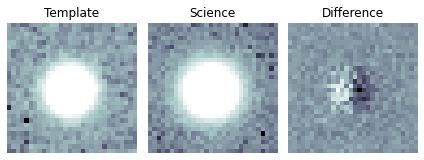

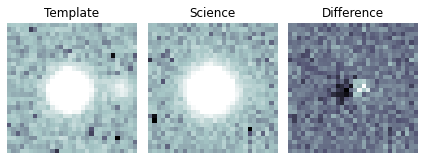

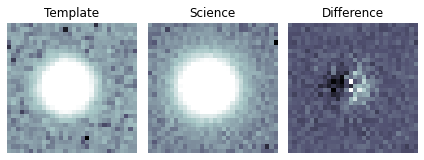

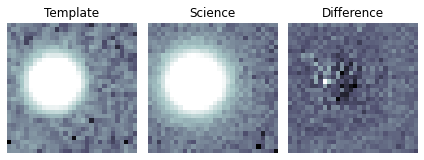

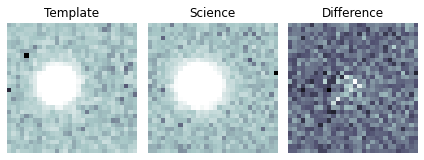

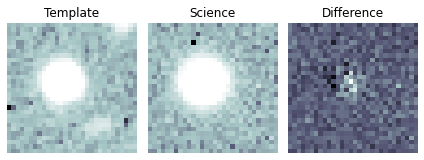

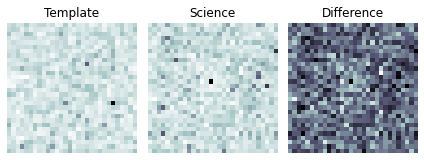

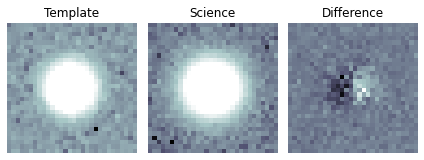

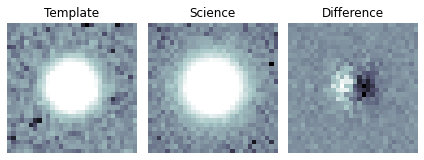

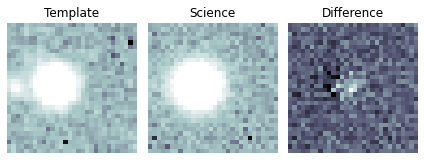

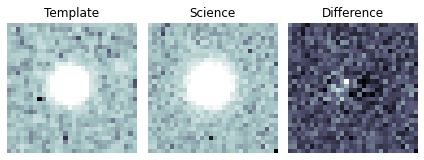

In [39]:
for idx, src in goodSrc.iterrows():
    data_id = {
        "detector": src.ccd,
        "visit": src.visit,
        "instrument": "LSSTCam-imSim",
    }
    center = lsst.geom.SpherePoint(src["ra"], src["decl"], lsst.geom.degrees)
    science, diff, template = plc.retrieveCutouts(butler, data_id, collection, center, diffName="goodSeeing")
    plc.plotCutout(science, diff, template)

And how about all the sources, including "bad" ones?

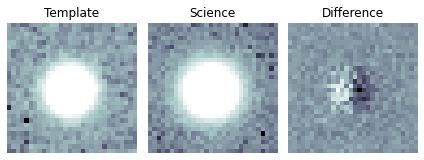

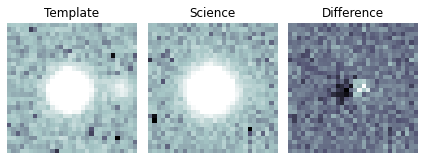

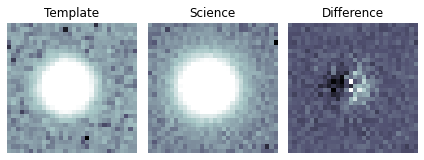

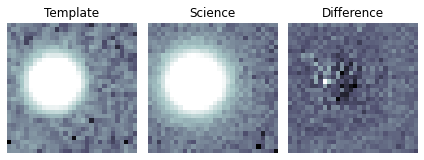

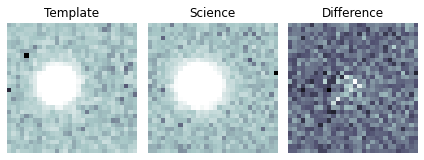

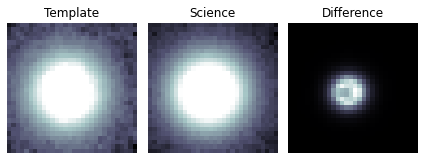

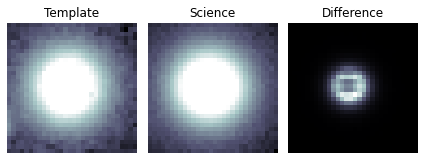

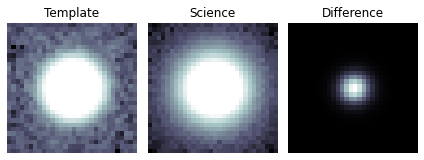

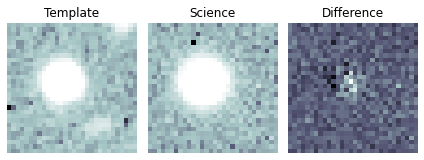

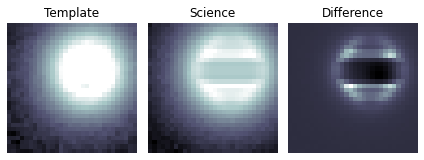

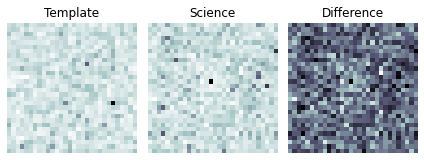

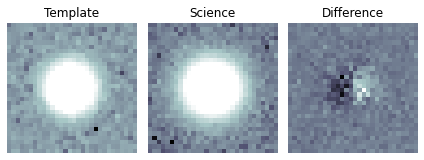

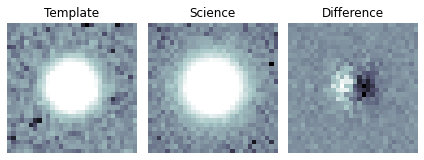

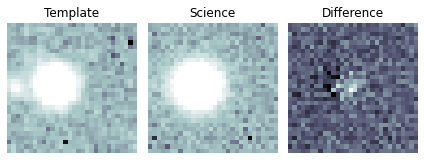

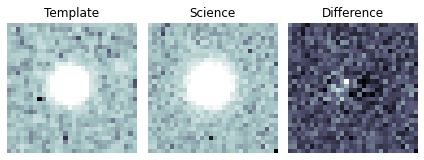

In [41]:
for idx, src in srcTable.iterrows():
    data_id = {
        "detector": src.ccd,
        "visit": src.visit,
        "instrument": "LSSTCam-imSim",
    }
    center = lsst.geom.SpherePoint(src["ra"], src["decl"], lsst.geom.degrees)
    science, diff, template = plc.retrieveCutouts(butler, data_id, collection, center, diffName="goodSeeing")
    plc.plotCutout(science, diff, template)